<a href="https://colab.research.google.com/github/Madeira-International-Workshop-in-ML/2021_day_4/blob/main/Notebooks/Example%203%20--%20GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Import the libraries
"""

# to develop the nn
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np # data manipulation
import random

from google.colab import files

import pathlib

In [ ]:
"""
Download the Shakespeare dataset
"""

path_to_file = tf.keras.utils.get_file('shakespeare.txt',
'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1122304/1115394 [==============================] - 0s 0us/step


In [ ]:
"""
Read the data
"""

# Read, then decode for py2 compat
text = open(path_to_file, 'rb').read().decode(encoding='utf-8') 

# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')  
vocab = sorted(set(text)) 
print(f'{len(vocab)} unique characters') # the unique characters in the file
print(f'All unique characters: {vocab}') # all unique characters in the file

Length of text: 1115394 characters
65 unique characters
All unique characters: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


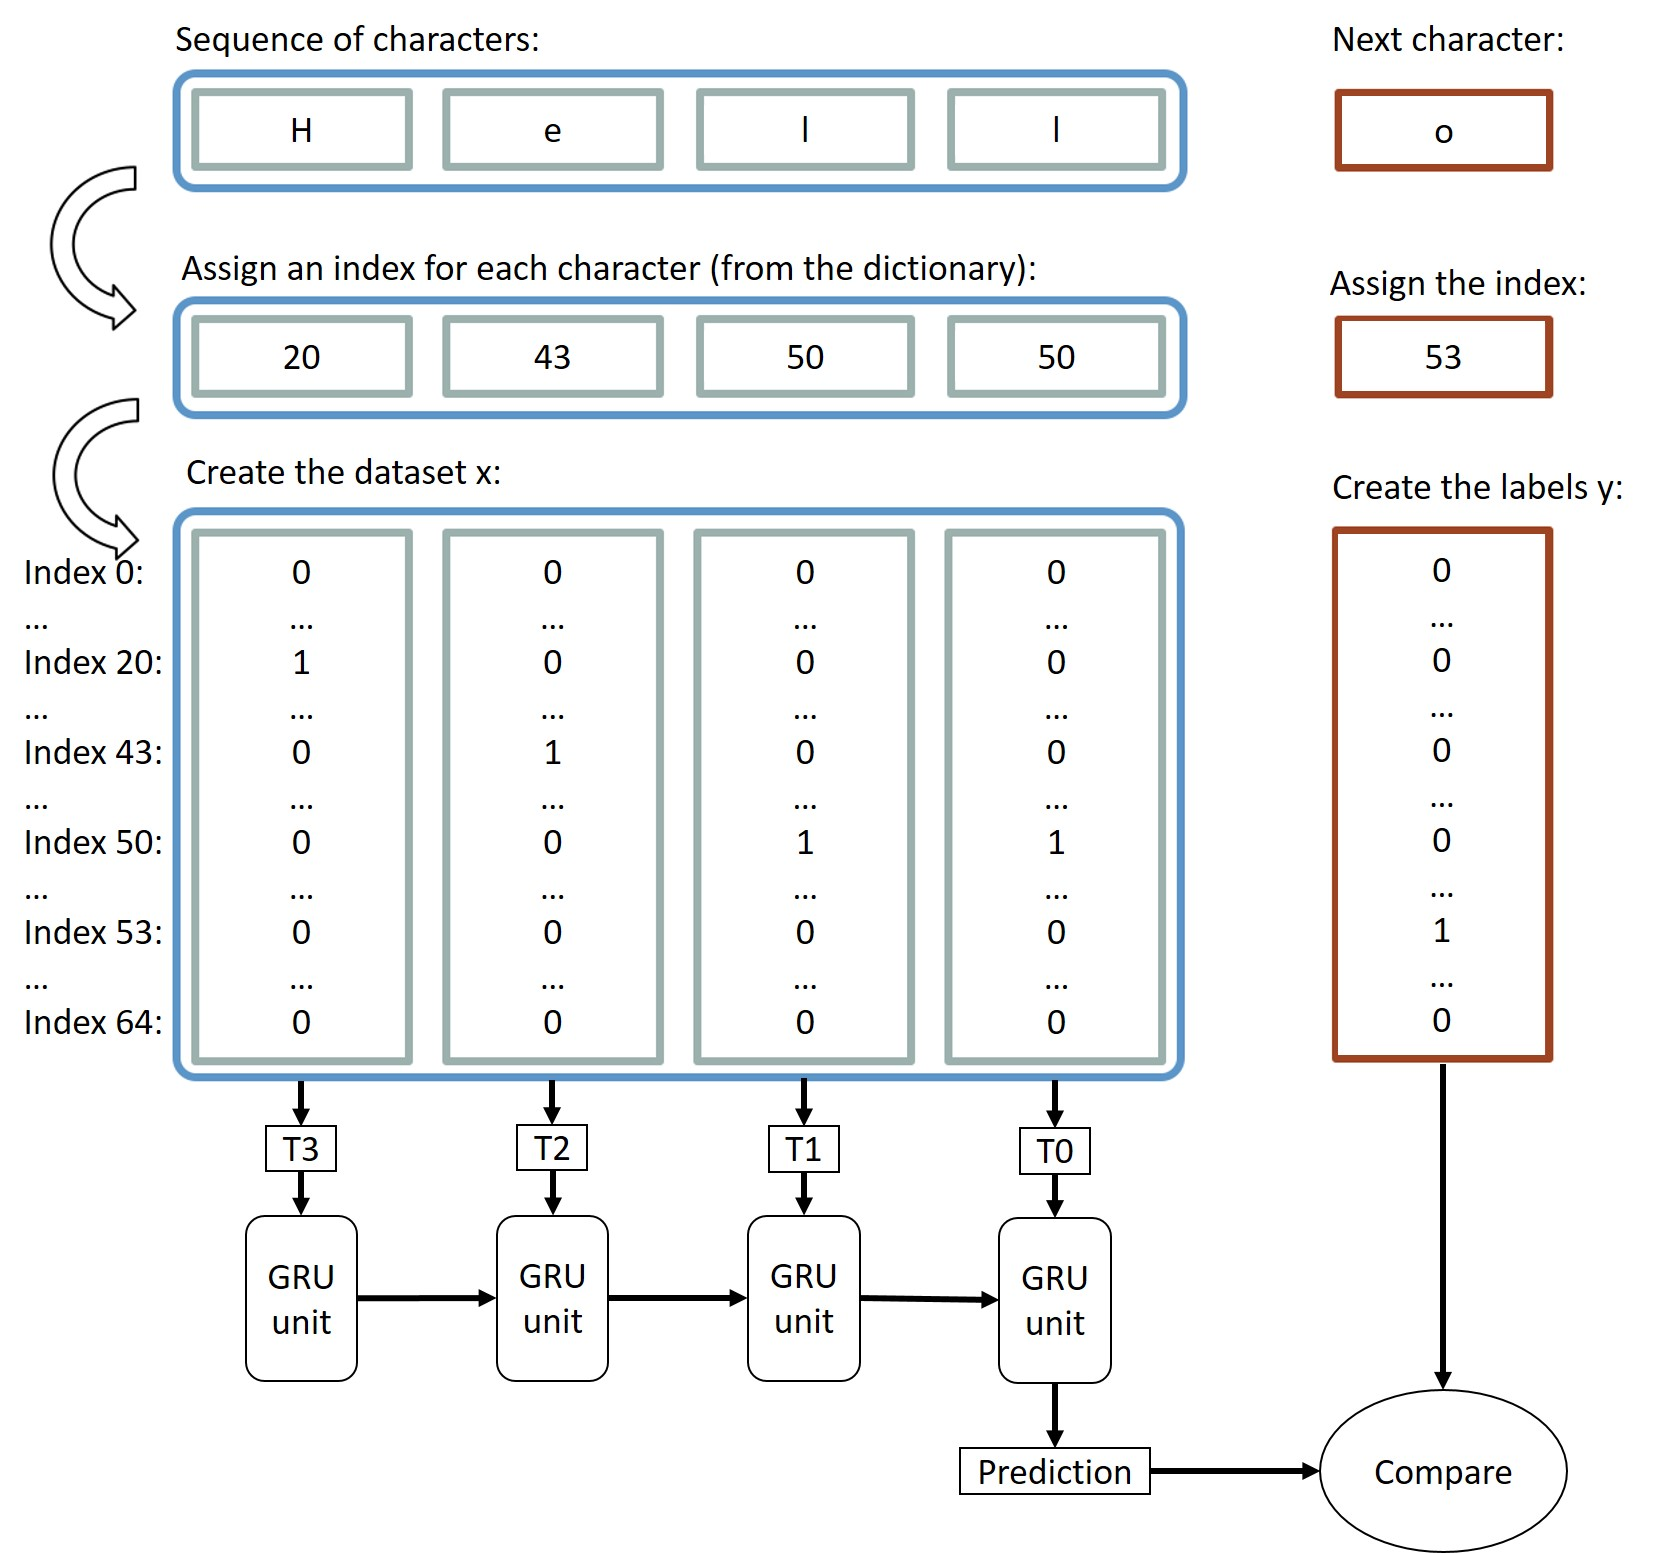

In [ ]:
"""
Data Pre-Processing
"""

# produce the sequence of 60 characters shifting forward 3 characters 
maxlen = 60 # extract sequences of length 60
step = 3 # number of character to shift forward 
sentences = []	# holds extracted sequences
next_chars = [] # holds the targets
for i in range(0, len(text)-maxlen, step):
	sentences.append(text[i:i+maxlen])
	next_chars.append(text[i+maxlen])

# before training, convert the strings to a numerical representation using 
# vectorization
chars = sorted(list(set(text))) # find all different characters
vocab_len = len(chars)
# assign a number to identify each character
char_indices = dict((char, chars.index(char)) for char in chars) 
print (f'Index for all characters: {char_indices}')
# produce the dataset
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
  for t, char in enumerate(sentence):
    x[i, t, char_indices[char]] = 1
  y[i, char_indices[next_chars[i]]] = 1

Index for all characters: {'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}


In [ ]:
"""
Building the nn
"""

# specify the model
model = tf.keras.models.Sequential()
model.add(layers.GRU(128, input_shape=(maxlen, vocab_len)))
model.add(layers.Dense(vocab_len, activation="softmax"))

# compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam")

# check the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               74880     
_________________________________________________________________
dense (Dense)                (None, 65)                8385      
Total params: 83,265
Trainable params: 83,265
Non-trainable params: 0
_________________________________________________________________


In [ ]:
"""
Sample the text characters according to the reweighted distribution
"""

# to run on GPU: Runtime->Change runtime type->Hardware Accelerator->GPU
# para correr em GPU: Tempo de execução->Alterar tipo de tempo de execução
# ->Acelerador de hardware->GPU

# estimate the new charcter to include in the sentence
def sample(preds):
  # determine the probability for each character to be the next to be selected
  preds = np.asarray(preds).astype('float64')
  preds = preds / np.sum(preds)
  # sample randomly once from a multinomial distribution characterized by the  
  # probability of each character to be selected next, in oderer to create 
  # diversity in the words and avoid stucking the model in a repetitive
  # sequence with very few characters
  probas = np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

# train the model
model.fit(x, y, batch_size=128)
# randomly selcted a part of the text to work as test dataset (the seed)
start_index = random.randint(0, len(text) - maxlen - 1)
generated_text =  's girl? What, Juliet!\n\nJULIET:\nHow now! who calls?\n\nNurse:\nY'
print('Seed to generate text: "' + generated_text + '"')
fullSentence = generated_text
for i in range(20): # estimate 50 characters after the seed
  # produce the test data (seed)
  sampled = np.zeros((1, maxlen, len(chars)))
  # continue the previous sentence to inclune one new character
  for t, char in enumerate(generated_text):
      sampled[0, t, char_indices[char]] = 1.
  # predict one new character
  preds = model.predict(sampled, verbose=0)[0]
  next_index = sample(preds)
  next_char = chars[next_index]
  # include the new character in the sentence
  generated_text += next_char
  # keep the same sime of the sentence to form the test dataset
  generated_text = generated_text[1:]
  fullSentence += next_char # save the full sentence
print('Generated text: "' + str(fullSentence) + '"')

2905/2905 [==============================] - 25s 6ms/step - loss: 2.2471
Seed to generate text: "o your hand. What muffled fellow's that?

Provost:
This is a"
Generated text: "o your hand. What muffled fellow's that?

Provost:
This is ailerak, bit thad nff"


In [ ]:
generated_text =  's girl? What, Juliet!\n\nJULIET:\nHow now! who calls?\n\nNurse:\nY'
print('Seed to generate text: "' + generated_text + '"')
fullSentence = generated_text
for i in range(400): # estimate 50 characters after the seed
  # produce the test data (seed)
  sampled = np.zeros((1, maxlen, len(chars)))
  # continue the previous sentence to inclune one new character
  for t, char in enumerate(generated_text):
      sampled[0, t, char_indices[char]] = 1.
  # predict one new character
  preds = model.predict(sampled, verbose=0)[0]
  next_index = sample(preds)
  next_char = chars[next_index]
  # include the new character in the sentence
  generated_text += next_char
  # keep the same sime of the sentence to form the test dataset
  generated_text = generated_text[1:]
  fullSentence += next_char # save the full sentence
print('Generated text: "' + str(fullSentence) + '"')

Seed to generate text: "s girl? What, Juliet!

JULIET:
How now! who calls?

Nurse:
Y"
Generated text: "s girl? What, Juliet!

JULIET:
How now! who calls?

Nurse:
You, ig ok is hemen then I's, us sopinhar forstilo.

FiNRO:
Ay bouOk aw,
Comusunk, an moke yef Morlence.

GERINGES:
This the lost
lotce be instining.
HreLt queenty
And And my siest will doth wall of lutsem rowt
Why lown herrsice, pour en hum home I be contare.
Gaitld and gabe ther tanod, Bum Lord plawis,
O ap cunbther lord never! de,
Ben of sunkento be diny hiok, hellfur;
Dut dend ono you his it up"


In [ ]:
# Export the SavedModel
export_dir = '/tmp/saved_model/1'
tf.saved_model.save(model, export_dir=export_dir)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: /tmp/saved_model/1/assets


INFO:tensorflow:Assets written to: /tmp/saved_model/1/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [ ]:
# Prepare path string
model_path = 'words.tflite'

# Save the model
tflite_model_file = pathlib.Path(model_path)
tflite_model_file.write_bytes(tflite_model)

130352

In [ ]:
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def sample(preds):
  preds = np.asarray(preds).astype('float64')
  preds = preds / np.sum(preds)
  probas = np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

def encode_char(char, vocab):
  arr = np.zeros(len(vocab))
  arr[vocab[char]] = 1
  return arr

def encode_sequence(char_seq, vocab):
  arr = np.zeros((1, len(char_seq), len(vocab)))
  for t, char in enumerate(char_seq):
      arr[0, t, vocab[char]] = 1
  return arr

n_characters_estimate = 400
vocab_len = len(chars)
max_len = 60

conversion_dict = {'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}


In [ ]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter('words.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
input = 's girl? What, Juliet!\n\nJULIET:\nHow now! who calls?\n\nNurse:\nY'

input_encoded = encode_sequence(input, conversion_dict)

final_sentense = input


for i in range(200): # estimate 400 characters after the seed
  # Select the input
  interpreter.set_tensor(input_index, input_encoded.astype(np.float32))

  # Run the model
  interpreter.invoke()
  output = interpreter.get_tensor(output_index)[0]

  # Predict one new character
  next_index = sample(output)
  next_char = chars[next_index]

  # Add to the final sentence
  final_sentense += next_char
  
  # Encode character
  next_char_encoded = encode_char(next_char, conversion_dict)

  # Append to the encoded array
  input_encoded[:, :-1, :] = input_encoded[:, 1:, :]
  input_encoded[:, -1, :] = next_char_encoded

print(final_sentense)

s girl? What, Juliet!

JULIET:
How now! who calls?

Nurse:
You do'teA ther wht king-hy hinks'-
RIShyor:
And my gray Hither at he and marp'stenter out fyie
char.
bo sein, wich one, lavi's, my belyWire ows?

for'd sorken?

GRUCEST:
You to ne, bid thich he,
Engqu


In [ ]:
input_encoded[:, -1, :]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]])